In [1]:
import sys
import os
import warnings
import time

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", "..", ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
warnings.filterwarnings("ignore")

In [2]:
from src.database.db_connection import *
from src.database.preparation import *
from src.utilities.step1_simplify_fds import *
from src.utilities.step2_clustering_and_generating_repairs import *
from src.utilities.step3_convert_back_to_db import *
from src.utilities.step4_group_similar_sentences import *
from src.evaluation.metrics import *
from src.database.db_connection import *

In [3]:
# inconsistent_df = pd.DataFrame([
#     [101, 'John Bell', 'UT', 19],
#     [101, 'James Bell', 'UT', 20],
#     [102, 'Claire Stevens', 'TUE', 20],
#     [102, 'Claire Stevens', 'TUE', 20]
# ], columns=['SID','SName','University','Age'])

In [4]:
engine = create_engine_for_db()

In [5]:
with engine.begin() as connection:
    connection.execute(text("""
    TRUNCATE TABLE prototype_fp_1.students_prob
    RESTART IDENTITY
    CASCADE;
    """))
    connection.execute(text("""
    UPDATE prototype_fp_1."_dict"
    SET dict = dictionary('')
    WHERE name = :name;
    """), {"name": "students_dict"})

In [6]:
fd_constraints = [(['sid', 'university'],['sname', 'address', 'postcode', 'emailid', 'phonenum'])]
#fd_constraints = [(['SID', 'University'],['SName', 'Age'])]

In [7]:
fd_constraints = simplify_FDs(fd_constraints)

In [8]:
fd_constraints

[(['sid', 'university'], ['sname']),
 (['sid', 'university'], ['address']),
 (['sid', 'university'], ['postcode']),
 (['sid', 'university'], ['emailid']),
 (['sid', 'university'], ['phonenum'])]

In [9]:
violation_levels = [{'target_violation_fraction':0.2, 'dups_per_cluster':(1,2), 'cells_corrupted':(1,2)},
{'target_violation_fraction':0.4, 'dups_per_cluster':(2,3), 'cells_corrupted':(2,3)},
{'target_violation_fraction':0.6, 'dups_per_cluster':(2,3), 'cells_corrupted':(3,4)},
{'target_violation_fraction':0.8, 'dups_per_cluster':(2,3), 'cells_corrupted':(3,4)}]

#violation_levels = [{'target_violation_fraction':0.2, 'dups_per_cluster':(1,2), 'cells_corrupted':(1,2)}]
# {'target_violation_fraction':0.5, 'dups_per_cluster':(2,3), 'cells_corrupted':(1,2)},
# {'target_violation_fraction':0.8, 'dups_per_cluster':(3,5), 'cells_corrupted':(2,3)},
# {'target_violation_fraction':1.0, 'dups_per_cluster':(6,10), 'cells_corrupted':(3,5)}]

num_inconsistent_relations = 20

delete_cost = 2
update_cost = 1
eps=1e-9
prob_type = 'UNIFORM'
constraint_hardness = [1.0] * len(fd_constraints)

query_file_name_expected_Prob = "../../../queries/FP/synthetic/Students_truth.sql"
query_file_name_actual_Prob = "../../../queries/FP/synthetic/Students_prob.sql"
algorithm_name = 'PRA'
old_table_name = ''
new_table_name = ''

j = 4
i = 1
table_name = f"students_{j}_{i}"

In [10]:
table_name = f"students_{j}_{i}"
inconsistent_df = pd.read_sql_table(table_name, con=engine, schema="prototype_fp_1")

In [11]:
start = time.perf_counter()
inconsistent_df = preprocess_data(inconsistent_df)
actions,cluster_ids,rv_probs = compute_actions(inconsistent_df, fd_constraints, constraint_hardness,delete_cost, update_cost,eps,prob_type)
all_actions,cartesian_possible,cartesian_computed = min_cost_actions_pruned(cluster_ids,actions,delete_cost,update_cost)

#repaired_versions =  apply_combined_actions(inconsistent_df, all_actions, uuid_col="uuid")
#repaired_versions = pd.concat(repaired_versions, ignore_index=True)
# repaired_versions = repaired_versions.drop(columns=["uuid"])
# rv_probabilities = filter_and_condition_min_cost_rvs(rv_probs, repaired_versions)
# repaired_df = group_similar_rows_together(repaired_versions)

In [12]:
repaired_versions =  apply_combined_actions(inconsistent_df, all_actions, uuid_col="uuid")

In [13]:
repaired_versions = pd.concat(repaired_versions, ignore_index=True)
repaired_versions = repaired_versions.drop(columns=["uuid"])

In [14]:
#rv_probabilities = filter_and_condition_min_cost_rvs(rv_probs, repaired_versions)
rv_probabilities = rv_probs

In [15]:
repaired_df = group_similar_rows_together(repaired_versions)
repaired_df.to_sql('students_prob',engine,schema='prototype_fp_1',index=False,if_exists='append')

37

In [16]:
entries = [f"{k}:{v}" for k, v in rv_probabilities.items()]
joined = ';'.join(entries)

update_stmt = f"UPDATE prototype_fp_1._dict\nSET dict=add(dict, '{joined}')\nWHERE name='students_dict';"
with engine.begin() as connection:
    connection.execute(text(update_stmt))

In [17]:
results_Prob,results_with_truth_set_prob = calculate_expected_values(query_file_name_expected_Prob, query_file_name_actual_Prob, algorithm_name,
                                                                             engine,old_table_name,new_table_name)
precision_prob, recall_prob,coverage_prob, noise_prob = summarize_results(results_Prob)

In [18]:
algorithm_name = 'CQA'
old_table_name = 'prototype_fp_1.students'
query_file_name_expected_CQA = "../../../queries/FP/synthetic/Students_truth.sql"
query_file_name_actual_CQA = "../../../queries/FP/synthetic/Students_CQA.sql"
results_CQA,results_with_truth_set_CQA = calculate_expected_values(query_file_name_expected_CQA, query_file_name_actual_CQA, algorithm_name, 
                                                                           engine,old_table_name, f"prototype_fp_1.{table_name}")
  
precision_CQA, recall_CQA,coverage_CQA, noise_CQA = summarize_results(results_CQA)

In [19]:
precision_prob

0.6794624926062541

In [20]:
recall_prob

0.20684431183012444

In [21]:
thresholds_uni = np.unique(np.concatenate([
    np.array([0.0]),
    np.logspace(-10, 0, 250)   # 1e-10 ... 1
]))
thresholds_cost = np.linspace(0.0, 1.0, 101)  # 0.00, 0.01, ..., 1.00

In [22]:
thresholds, avg_precision, avg_recall, avg_f1= compute_precision_recall_at_thresholds(results_with_truth_set_prob,thresholds_uni)

In [23]:
# plot_precision_recall_at_p(thresholds, avg_precision, avg_recall, avg_f1,precision_CQA, recall_CQA)

In [24]:
cqa_f1 = 2 * (precision_CQA * recall_CQA) / (precision_CQA + recall_CQA)

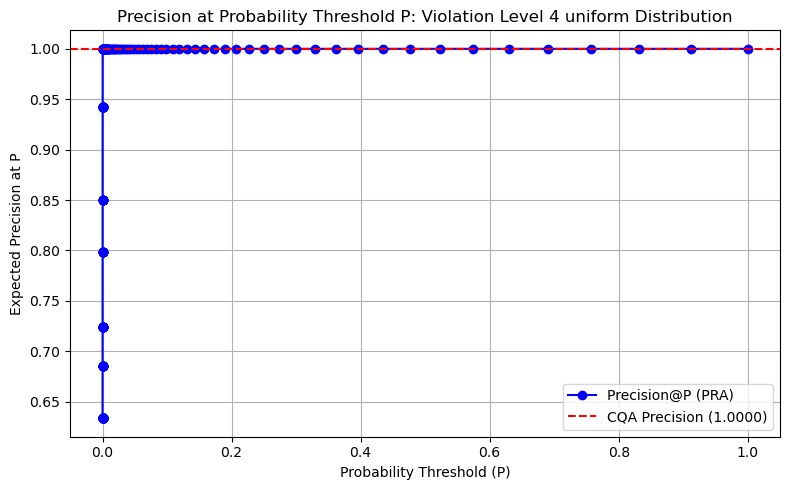

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, avg_precision, marker='o', label='Precision@P (PRA)', color='blue')
plt.axhline(y=precision_CQA, color='red', linestyle='--', label=f'CQA Precision ({precision_CQA:.4f})')
plt.xlabel("Probability Threshold (P)")
plt.ylabel("Expected Precision at P")
plt.title("Precision at Probability Threshold P: Violation Level 4 uniform Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

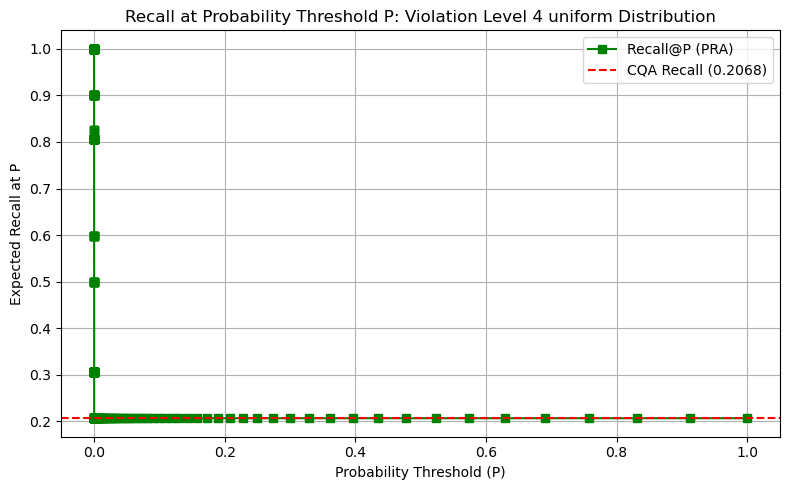

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, avg_recall, marker='s', label='Recall@P (PRA)', color='green')
plt.axhline(y=recall_CQA, color='red', linestyle='--', label=f'CQA Recall ({recall_CQA:.4f})')
plt.xlabel("Probability Threshold (P)")
plt.ylabel("Expected Recall at P")
plt.title("Recall at Probability Threshold P: Violation Level 4 uniform Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

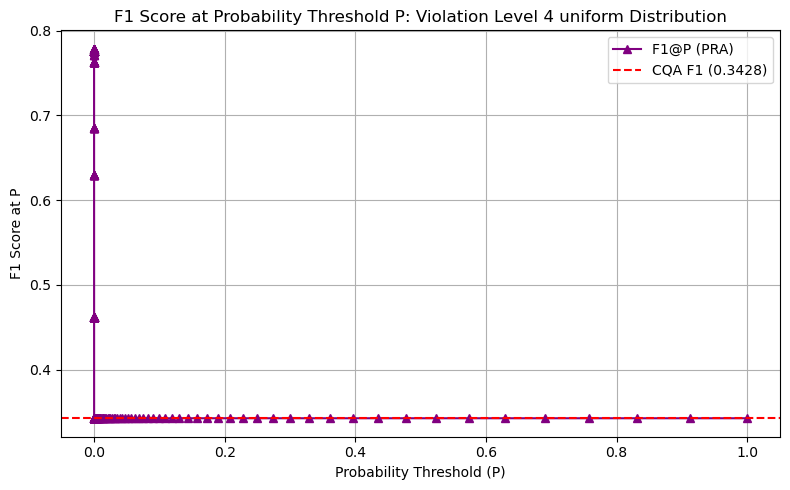

In [27]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, avg_f1, marker='^', label='F1@P (PRA)', color='purple')
plt.axhline(y=cqa_f1, color='red', linestyle='--', label=f'CQA F1 ({cqa_f1:.4f})')
plt.xlabel("Probability Threshold (P)")
plt.ylabel("F1 Score at P")
plt.title("F1 Score at Probability Threshold P: Violation Level 4 uniform Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()